In [22]:
%pip uninstall torch torchvision torchaudio torchtext torchdata fastai -y
%pip install torchvision==0.16 torch==2.1

import torch
import torchvision

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("pytorch", torch.__version__)
print("torchvision", torchvision.__version__)


  Using cached torchvision-0.16.0-cp310-cp310-manylinux1_x86_64.whl (6.9 MB)
  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)


pytorch 2.1.0+cu121
torchvision 0.16.0+cu121


In [34]:
from torchvision.transforms import functional as F
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive, verify_str_arg
from torchvision.ops import box_area

from PIL import Image

import collections
import os
from xml.etree.ElementTree import Element as ET_Element

try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse
from typing import Any, Callable, Dict, List, Optional, Tuple


class FracAtlasDetection(VisionDataset):
    """FracAtlas dataset."""

    def __init__(
        self,
        root: str,
        image_set: str = "train",
        # download: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ):
        super().__init__(root, transforms, transform, target_transform)

        valid_image_sets = ["test", "train", "valid"]
        self.image_set = verify_str_arg(image_set, "image_set", valid_image_sets)

        self.url = "https://figshare.com/ndownloader/files/41725659"
        self.filename = "fracatlas.zip"

        # if download:
        if not os.path.isdir("data/FracAtlas"):
            os.makedirs("data", exist_ok=True)
            download_and_extract_archive(self.url, os.path.dirname(self.root), filename=self.filename, remove_finished=True)
            for subdir in ["Fractured", "Non_fractured"]:
                dirpath = os.path.join(self.root, "images")
                subdirpath = os.path.join(dirpath, subdir)
                for f in os.listdir(subdirpath):
                    if not f.lower().endswith(".jpg"): continue
                    os.rename(os.path.join(subdirpath, f), os.path.join(dirpath, f))
                os.rmdir(subdirpath)
            print(os.listdir("data"))
        if not os.path.isdir(self.root):
            raise RuntimeError(
                "Dataset not found or corrupted. You can use download=True to download it"
            )

        splits_dir = os.path.join(self.root, "Utilities", "Fracture Split")
        splits_f = os.path.join(splits_dir, image_set.rstrip("\n") + ".csv")
        with open(os.path.join(splits_f)) as f:
            file_names = [
                os.path.splitext(x.strip())[0]
                for x in f.readlines()
                if x.strip() != "image_id"
            ]

        image_dir = os.path.join(self.root, "images")
        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]

        target_dir = os.path.join(self.root, "Annotations", "PASCAL VOC")
        self.targets = [os.path.join(target_dir, x + ".xml") for x in file_names]

        assert len(self.images) == len(self.targets)

    @property
    def annotations(self) -> List[str]:
        return self.targets

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """
        img = Image.open(self.images[index]).convert("RGB")
        img = F.to_tensor(img)
        voc_dict = self.parse_voc_xml(ET_parse(self.annotations[index]).getroot())
        target = self.voc_dict_to_target(index, voc_dict)
        # print(target)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self) -> int:
        return len(self.images)

    @staticmethod
    def parse_voc_xml(node: ET_Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(FracAtlasDetection.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {
                node.tag: {
                    ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()
                }
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

    def voc_dict_to_target(self, index: int, item):
        width = int(item["annotation"]["size"]["width"])
        height = int(item["annotation"]["size"]["height"])

        num_fractures = len(item["annotation"]["object"])

        boxes = [
            (
                int(obj["bndbox"]["xmin"]),
                int(obj["bndbox"]["ymin"]),
                int(obj["bndbox"]["xmax"]),
                int(obj["bndbox"]["ymax"]),
            )
            for obj in item["annotation"]["object"]
        ]

        # guard against no boxes via resizing (https://github.com/pytorch/vision/blob/aa32c9376c46eb284f2b091f3eb98aec4fd64b03/references/detection/coco_utils.py#L63-L66)
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        # boxes[:, 2:] += boxes[:, :2]
        # boxes[:, 0::2].clamp_(min=0, max=width)
        # boxes[:, 1::2].clamp_(min=0, max=height)

        # extract labels
        labels = torch.ones((num_fractures,), dtype=torch.int64)

        image_id = index
        area = box_area(boxes)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_fractures,), dtype=torch.int64)

        # remove invalid boxes (https://github.com/pytorch/vision/blob/aa32c9376c46eb284f2b091f3eb98aec4fd64b03/references/detection/coco_utils.py#L82-L85)
        # keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        # boxes = boxes[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return target


In [24]:
# from torchvision.transforms import v2 as T


# def get_transform(train):
#     transforms = []
#     # if train:
#     #     transforms.append(T.RandomHorizontalFlip(0.5))
#     transforms.append(T.ToImage())
#     transforms.append(T.ToDtype(torch.float32, scale=True))
#     # transforms.append(T.ToDtype(torch.float))
#     # transforms.append(T.ToPureTensor())
#     return T.Compose(transforms)


In [25]:
# os.makedirs("lib", exist_ok=True)
if not os.path.exists("engine.py"):
    os.system(
        "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py -O engine.py"
    )
if not os.path.exists("utils.py"):
    os.system(
        "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py -O utils.py"
    )
if not os.path.exists("transforms.py"):
    os.system(
        "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py -O transforms.py"
    )
if not os.path.exists("coco_utils.py"):
    os.system(
        "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py -O coco_utils.py"
    )
if not os.path.exists("coco_eval.py"):
    os.system(
        "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py -O coco_eval.py"
    )

# you also need to tweak them a bit to work with relative imports


In [45]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from utils import collate_fn

model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
dataset = FracAtlasDetection("data/FracAtlas", image_set="train", transform=None)
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=2,
  shuffle=True,
  num_workers=4,
  collate_fn=collate_fn,
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 105MB/s]


{'loss_classifier': tensor(0.0772, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0191, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1087, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0079, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


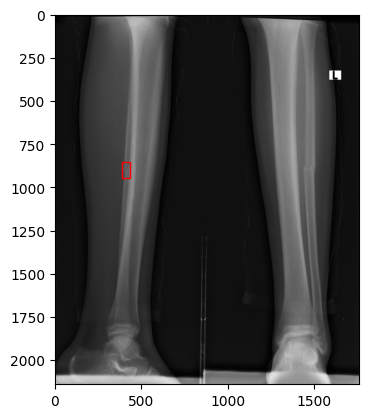

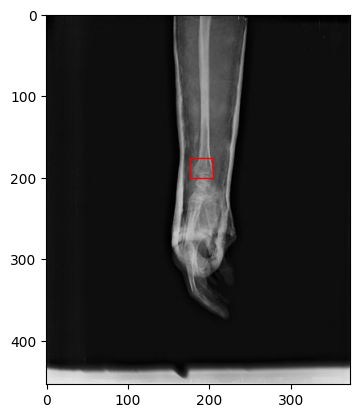

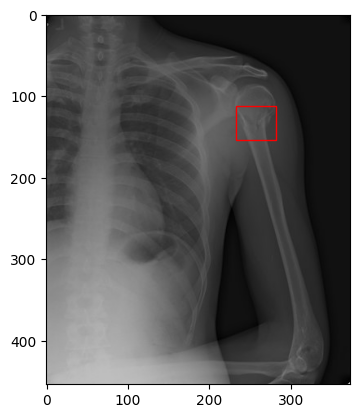

In [46]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import v2 as T

def xyxy_to_xywh(xyxy):
    """
    Convert XYXY format to XYWH format (x,y center point and width, height).
    :param xyxy: [XMIN, YMIN, XMAX, YMAX]
    :return: [X, Y, W, H]
    """
    if len(xyxy) > 4:
        raise ValueError('xyxy format: [x1, y1, x2, y2]')
    x = xyxy[0]
    y = xyxy[1]
    w = xyxy[2] - xyxy[0]
    h = xyxy[3] - xyxy[1]
    return x, y, w, h


for di in [random.randint(0, len(dataset)) for _ in range(3)]:
    d = dataset[di]
    # print(d)
    im = T.ToPILImage()(d[0])

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)

    boxes = d[1]["boxes"].tolist()

    # print(boxes)

    if len(boxes) > 0:
        if type(boxes[0]) == list:
            boxes = boxes[0]
        x,y,w,h = xyxy_to_xywh(boxes)

        # Create a Rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


In [48]:
from engine import train_one_epoch, evaluate
from utils import collate_fn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:", device)

# use our dataset and defined transformations
dataset = FracAtlasDetection('data/FracAtlas', image_set="train", transform=None)
dataset_test = FracAtlasDetection('data/FracAtlas', image_set="test", transform=None)
dataset_val = FracAtlasDetection('data/FracAtlas', image_set="valid", transform=None)

# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=3,
#     gamma=0.1
# )

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("Val")
coco_test_evaluator = evaluate(model, data_loader_val, device=device)
for coco_eval in coco_test_evaluator.coco_eval.values():
    print("Precision/valid", coco_eval.eval["precision"])

print("That's it!")

print("Saving")
torch.save(model, 'fracatlas_fasterrcnn-resnet50_v4.pth')
print("Saved")


device: cuda
Epoch: [0]  [  0/287]  eta: 0:09:27  lr: 0.000022  loss: 0.3409 (0.3409)  loss_classifier: 0.1176 (0.1176)  loss_box_reg: 0.0115 (0.0115)  loss_objectness: 0.2055 (0.2055)  loss_rpn_box_reg: 0.0063 (0.0063)  time: 1.9759  data: 0.7709  max mem: 5110
Epoch: [0]  [ 10/287]  eta: 0:03:51  lr: 0.000197  loss: 0.2345 (0.2659)  loss_classifier: 0.0919 (0.1016)  loss_box_reg: 0.0115 (0.0160)  loss_objectness: 0.1438 (0.1416)  loss_rpn_box_reg: 0.0063 (0.0067)  time: 0.8371  data: 0.0911  max mem: 5110
Epoch: [0]  [ 20/287]  eta: 0:03:27  lr: 0.000372  loss: 0.2345 (0.2584)  loss_classifier: 0.0704 (0.0874)  loss_box_reg: 0.0052 (0.0132)  loss_objectness: 0.1434 (0.1501)  loss_rpn_box_reg: 0.0070 (0.0076)  time: 0.7182  data: 0.0197  max mem: 5110
Epoch: [0]  [ 30/287]  eta: 0:03:13  lr: 0.000546  loss: 0.2383 (0.2616)  loss_classifier: 0.0704 (0.0875)  loss_box_reg: 0.0102 (0.0142)  loss_objectness: 0.1410 (0.1516)  loss_rpn_box_reg: 0.0079 (0.0083)  time: 0.7082  data: 0.0165  m